In [1]:
# Copyright (c) 2019 ETH Zurich, Lukas Cavigelli, Georg Rutishauser, Luca Benini

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

from dataCollect import getModel, getFMs
from analysisTools import Analyzer

In [2]:
#instantiate dataset loader and pre-trained model
training = True

epoch = None
# modelName = 'resnet34'
# modelName = 'squeezenet'
modelName = 'alexnet'
# modelName = 'vgg16'
# modelName = 'mobilenet2'
# modelName, epoch = 'alexnet-cust', 54
# modelName, epoch = 'mobilenetV2-cust', 200

model, loss_func = getModel(modelName, epoch=epoch)

In [3]:
# gather feature maps
model.eval()
analyzer = Analyzer(quantMethod='fixed16', compressor=None)
outputsReLU, _, _, gradsReLU = getFMs(model, loss_func, 
                                      training=training, computeGrads=True,
                                      numBatches=1, batchSize=10)#250)

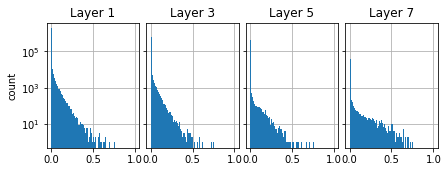

In [4]:
#histogram 
outputLayerIdxs = np.linspace(0, len(gradsReLU)-1, 4).round().astype(np.int)
useDiffs = [False]*len(outputLayerIdxs)
#alexnet
# outputLayerIdxs = [0,2,4,6]
# useDiffs = [False]*len(outputLayerIdxs)
#squeezeNet
# outputLayerIdxs = [1, 13, 25]
# useDiffs = [False]*3
nonZeroOnly = False # select whether to exclude zero values
_, axarr = plt.subplots(ncols=len(outputLayerIdxs), sharey=True, figsize=(7,2.3))
plt.subplots_adjust(wspace=0.08)
for idx, ud, ax in zip(outputLayerIdxs, useDiffs, axarr):
  ax.set_title('Layer %d%s' % (idx+1,', diffs' if ud else ''))
#   histtmp = outputs[idx].view(-1).numpy()
  histtmp = gradsReLU[idx].view(-1).numpy()
  if nonZeroOnly:
    histtmp = histtmp[histtmp.nonzero()]
  if ud:
    histtmp = histtmp[1:] - histtmp[:-1]
    bins = np.linspace(-1,1,81)
  else:
    bins = np.linspace(0,1,81)
  ax.hist(histtmp, bins=bins, log=True)
  ax.grid(True)
axarr[0].set_ylabel('count')

plt.savefig('figs/histogram-%s.pdf' % modelName, bbox_inches='tight', pad_inches=0.0)

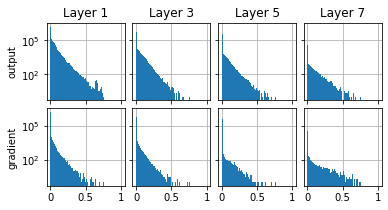

In [5]:
#histogram 
layerIdxs =np.linspace(0, len(outputsReLU)-1, 4).round().astype(np.int)
fig, axarrs = plt.subplots(ncols=len(layerIdxs), nrows=2, figsize=(6,3), 
                          gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, 
                          sharey=True, sharex=True, squeeze=True)

for idxOut, (tensor, name) in enumerate(zip([outputsReLU, gradsReLU], ['output', 'gradient'])):
    axarr = [axarrs[idxOut][i] for i in range(len(layerIdxs))]
    
    useDiffs = [False]*len(layerIdxs)
    nonZeroOnly = False 
    plt.subplots_adjust(wspace=0.08)
    for idx, ud, ax in zip(layerIdxs, useDiffs, axarr):
        plt.sca(ax)
        if idxOut == 0:
            plt.title('Layer %d%s' % (idx+1,', diffs' if ud else ''))
        histtmp = tensor[idx].view(-1).numpy()
        if nonZeroOnly:
            histtmp = histtmp[histtmp.nonzero()]
        if ud:
            histtmp = histtmp[1:] - histtmp[:-1]
            bins = np.linspace(-1,1,81)
        else:
            bins = np.linspace(0,1,81)
        plt.hist(histtmp, bins=bins, log=True)
        plt.grid(True)
        if idx == 0:
            plt.ylabel(name)
        if idxOut == 1:
            plt.xticks(ticks=[0,0.5,1], labels=['0','0.5','1'])

plt.savefig('figs/histogram-%s-joint.pdf' % (modelName), bbox_inches='tight', pad_inches=0.0)